In [1]:
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore","UserWarning")
warnings.filterwarnings("ignore","RuntimeWarning")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D
from netCDF4 import Dataset
import matplotlib.ticker as ticker
import xarray
import scipy.ndimage as ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import make_interp_spline
import glob,os
from scipy import interpolate
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
#My script
import ceilometer_help
import peak_finding
import display
from copy import deepcopy
from tqdm import tqdm
from scipy.signal import savgol_filter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
cps08_folder = "/scra6/ft21894/py_script/TAHOPE/Data/CPS08_ceilometer/processed/proc/diurnal/"
filelistCPS = sorted(glob.glob(cps08_folder+'*'))
del cps08_folder

dataCPS = []
for i in range(len(filelistCPS)):
    dataCPS.append(xarray.open_dataset(filelistCPS[i]))

CWTpeak_CPS,backscatterCPS,gpeak_CPS = [],[],[]
for i in range(len(filelistCPS)):
    CWTpeak_CPS.append(dataCPS[i]['CWTpeak_out'])
    backscatterCPS.append(dataCPS[i]['scatterer_out'])
    gpeak_CPS.append(dataCPS[i]['gpeak_out'])

In [9]:
def adjust_temp(CWTarray=None,scatter_array=None,zero_h=50,kdepeak=1,TYPE='morning'):
    tmp = deepcopy(CWTarray)
    tmpc = peak_finding.CWT_transform(scatter_array).clean_peak(peakloc=
                                                                tmp,TYPE='NO_ZERO',zero_loc=zero_h)
    for i in range(0,4):
        NAN = np.isnan(tmpc[:,i])
        tmpc[:,i][NAN] = 0
        del NAN    
    return tmpc
def output_KDEh(cleanedpeak=None,peakindex=None,scatter_array=None,intrpsize=None,xinfo=None,yinfo=None,
                plt_value=3e-6):
    for num,index in enumerate(peakindex):
        fdisttmp,CWTtmp,CWTtmpintrp = \
            peak_finding.CWT_transform(scatter_array).KDE_manual(xinfo=xinfo,yinfo=yinfo,
                                                    peakloc=cleanedpeak,peaklocINDEX=index)
        fdisttmpintrp = np.zeros((xinfo[1],yinfo[1]))
        for i in range(yinfo[1]):
            fdisttmpintrp[:,i] = np.interp(intrpsize,
                                           np.linspace(0,xinfo[1]-1,200),fdisttmp[i,:])
        B_KDE = lowess(CWTtmpintrp,intrpsize,return_sorted=False,
                              is_sorted=True, frac=0.15, it=0)
        B_KDE3e = lowess(peak_finding.peak_from_KDE(fdisttmpintrp).
                                find_index(values=plt_value),
                                intrpsize,return_sorted=False,is_sorted=True, frac=0.15, it=0)
        B_KDE3e_up = lowess(peak_finding.peak_from_KDE(fdisttmpintrp).
                                   find_index(values=plt_value,TYPE='upper'),
                                   intrpsize,return_sorted=False,is_sorted=True, frac=0.15, it=0)
        del fdisttmp,CWTtmp,CWTtmpintrp,fdisttmpintrp
        return B_KDE,B_KDE3e,B_KDE3e_up

adjust_const=[30,37,25,25]
CWTpeak_CPSn = []
for i in range(4):
    CWTpeak_CPSn.append(adjust_temp(CWTarray=CWTpeak_CPS[i][0:225*18,:],
                        scatter_array=backscatterCPS[i][:,0:200],zero_h=adjust_const[i],kdepeak=1,TYPE='morning'))

In [10]:
CPSpeak_a,CPSpeak_up,CPSpeak_down = [],[],[]
for i in range(4):
    test1,test2,test3 = output_KDEh(CWTpeak_CPSn[i],[1],backscatterCPS[i][:,0:200],
                                    np.linspace(0,225*18-1,225*18),[0, 225*18, 200j,200],[0, 200, 200j,200])
    CPSpeak_a.append(test1)
    CPSpeak_up.append(test2)
    CPSpeak_down.append(test3)

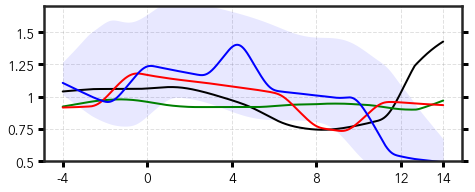

In [11]:
sns.set_style('white')
sns.set_context('poster',font_scale=0.6)
prop = fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/avenir next/AvenirNextLTPro-Regular.otf')

ytick = [25*20,37.5*20,50*20,62.5*20,75*20]
yticklbls = [0.5,0.75,1,1.25,1.5]
xtick = [0,225*4,225*8,225*12,225*16,225*18]
xticklbls = [-4,0,4,8,12,14]
        
fig = plt.figure(figsize=(7.5,2.85))
ax = fig.add_subplot(1,1,1)
plt.plot(CPSpeak_a[0]*20,lw=2,c='k')
#ax.fill_between(np.linspace(0,225*18-1,225*18), CPSpeak_down[0]*20, CPSpeak_up[0]*20, 
#                alpha=0.091,color='k',linewidths=0)
plt.plot(CPSpeak_a[1]*20,lw=2,c='g')
#ax.fill_between(np.linspace(0,225*18-1,225*18), CPSpeak_down[1]*20, CPSpeak_up[1]*20, 
#                alpha=0.091,color='g',linewidths=0)
plt.plot(CPSpeak_a[2]*20-6*20,lw=2,c='r')
#ax.fill_between(np.linspace(0,225*18-1,225*18), CPSpeak_down[2]*20-6*20, CPSpeak_up[2]*20-6*20, 
#                alpha=0.091,color='r',linewidths=0)
plt.plot(CPSpeak_a[3]*20-6*20,lw=2,c='b')
ax.fill_between(np.linspace(0,225*18-1,225*18), CPSpeak_down[3]*20-6*20, CPSpeak_up[3]*20-6*20, 
                alpha=0.091,color='b',linewidths=0)
ax.grid(lw=1,alpha=0.23,c='gray',ls='--')
ax.set_yticks(ytick)
ax.set_yticklabels(yticklbls,fontproperties=prop,fontsize=13.5)
ax.set_xticks(xtick)
ax.set_xticklabels(xticklbls,fontproperties=prop,fontsize=13.5)
ax.tick_params(direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.set_ylim(500,1700)
plt.show()